In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, TimeDistributed
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
import matplotlib.pyplot as plt

In [3]:
np.random.seed(7)
tf.random.set_seed(7)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
csv_path = '/content/drive/MyDrive/AI/Files/train.csv'
train = pd.read_csv(csv_path, parse_dates=["date"])
train = train.query("store == 1 and item == 1").copy()
train = train.sort_values("date")
print(train.head())
print(len(train))

        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
1826


In [9]:
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
1821,2017-12-27,1,1,14
1822,2017-12-28,1,1,19
1823,2017-12-29,1,1,15
1824,2017-12-30,1,1,27


In [10]:
def make_supervised_windows(series: np.ndarray, window: int, lag: int):
  X, y = [], []
  for i in range(window, len(series)-lag):
    X.append(series[i-window:i+1])
    y.append(series[i+lag])
  return np.array(X), np.array(y)
window = 29
lag = 1

X, y = make_supervised_windows(train["sales"].values, window, lag)
print("X",X.shape,"y", y.shape)

X (1796, 30) y (1796,)


In [11]:
cut = int(len(X) * 0.8)
X_train, y_train = X[:cut], y[:cut]
X_test, y_test = X[cut:], y[cut:]

scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))

X_train_s = scaler_x.transform(X_train)
X_test_s = scaler_x.transform(X_test)

y_train_s = scaler_y.transform(y_train.reshape(-1,1)).ravel()
y_test_s = scaler_y.transform(y_test.reshape(-1,1)).ravel()

print("X_train_s",X_train_s, "y_train_s", y_train_s.shape)

X_train_s [[-0.98253317 -1.2868465  -0.83220313 ... -1.3187656  -2.08691314
  -1.62921404]
 [-1.28605422 -0.83143413 -0.98407042 ... -2.08733192 -1.62584223
  -1.01358313]
 [-0.83077264 -0.98323826 -1.43967229 ... -1.62619213 -1.011081
  -1.32139859]
 ...
 [ 0.68683264 -0.98323826 -1.43967229 ... -0.85762581 -0.08893917
  -0.70576768]
 [-0.98253317 -1.43865062 -0.37660127 ... -0.0890595  -0.70370039
  -1.47530632]
 [-1.43781475 -0.37602177 -0.68033584 ... -0.70391255 -1.47215192
  -0.55185995]] y_train_s (1436,)


In [12]:
x_train_3d = X_train_s.reshape((len(X_train_s), window+1, 1))
x_test_3d = X_test_s.reshape((len(X_test_s), window+1, 1))

In [13]:
print("Train 3d:",x_train_3d)
print("Test 3d:",x_test_3d)

Train 3d: [[[-0.98253317]
  [-1.2868465 ]
  [-0.83220313]
  ...
  [-1.3187656 ]
  [-2.08691314]
  [-1.62921404]]

 [[-1.28605422]
  [-0.83143413]
  [-0.98407042]
  ...
  [-2.08733192]
  [-1.62584223]
  [-1.01358313]]

 [[-0.83077264]
  [-0.98323826]
  [-1.43967229]
  ...
  [-1.62619213]
  [-1.011081  ]
  [-1.32139859]]

 ...

 [[ 0.68683264]
  [-0.98323826]
  [-1.43967229]
  ...
  [-0.85762581]
  [-0.08893917]
  [-0.70576768]]

 [[-0.98253317]
  [-1.43865062]
  [-0.37660127]
  ...
  [-0.0890595 ]
  [-0.70370039]
  [-1.47530632]]

 [[-1.43781475]
  [-0.37602177]
  [-0.68033584]
  ...
  [-0.70391255]
  [-1.47215192]
  [-0.55185995]]]
Test 3d: [[[-0.37549106]
  [-0.67963001]
  [-1.89527416]
  ...
  [-1.47247886]
  [-0.55001008]
  [-0.85967541]]

 [[-0.67901211]
  [-1.89406298]
  [-1.13593771]
  ...
  [-0.55019928]
  [-0.8573907 ]
  [ 0.67940187]]

 [[-1.89309633]
  [-1.13504238]
  [ 0.0790006 ]
  ...
  [-0.85762581]
  [ 0.67951236]
  [-0.85967541]]

 ...

 [[ 1.29387475]
  [-0.67963001]
 

In [14]:
# CNN 1D
model_cnn = Sequential([
    Conv1D(filters=32, activation="relu", kernel_size=3, input_shape=(window+1, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(1)
])
model_cnn.compile(optimizer="adam", loss="mse")
model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        14,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,529 (56.75 KB)

 Trainable params: 14,529 (56.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn = model_cnn.fit(x_train_3d, y_train_s, epochs=50, batch_size=32, verbose=1)

In [19]:
# Predictions
pred_cnn_s = model_cnn.predict(x_test_3d).ravel()
pred_cnn = scaler_y.inverse_transform(pred_cnn_s.reshape(-1, 1)).ravel()
print("RMSE:", sqrt(mean_squared_error(y_test, pred_cnn)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
RMSE: 6.57959170990813


In [20]:
# LSTM
model_lstm = Sequential([
    LSTM(32, activation="tanh", input_shape=(window+1, 1)),
    Dense(1)
])
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm = model_lstm.fit(x_train_3d, y_train_s, epochs=50, batch_size=32, verbose=1)

In [22]:
pred_lstm_s = model_lstm.predict(x_test_3d).ravel()
pred_lstm = scaler_y.inverse_transform(pred_lstm_s.reshape(-1, 1)).ravel()
print("RMSE:", sqrt(mean_squared_error(y_test, pred_lstm)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 5.256906779983131


In [29]:
# CNN + LSTM
subseq = 5
assert (window+1) % subseq == 0, "window must be divisible by subseq"
steps_per_subseq = (window+1) // subseq

Xtr4 = x_train_3d.reshape((len(x_train_3d), subseq, steps_per_subseq, 1))
Xva4 = x_test_3d.reshape((len(x_test_3d), subseq, steps_per_subseq, 1))

model_cnn_lstm = Sequential([
    TimeDistributed(Conv1D(filters=32, activation="relu", kernel_size=3),
                    input_shape=(subseq, steps_per_subseq, 1)),
    TimeDistributed(MaxPooling1D(2)),
    TimeDistributed(Flatten()),
    LSTM(32, activation="tanh"),
    Dense(1)
])
model_cnn_lstm.compile(optimizer="adam", loss="mse")
model_cnn_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_8              │ (None, 5, 4, 32)       │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 5, 2, 32)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 5, 64)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,577 (49.13 KB)

 Trainable params: 12,577 (49.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn_lstm = model_cnn_lstm.fit(Xtr4, y_train_s, epochs=50, batch_size=32, verbose=1)

In [31]:
# Xva4 is the test samples
pred_cnn_lstm_s = model_cnn_lstm.predict(Xva4).ravel()
pred_cnn_lstm = scaler_y.inverse_transform(pred_cnn_lstm_s.reshape(-1, 1)).ravel()
print("RMSE:", sqrt(mean_squared_error(y_test, pred_cnn_lstm)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
RMSE: 7.584685767447322


In [33]:
# plotting results
import matplotlib.pyplot as plt

rmse_cnn = sqrt(mean_squared_error(y_test, pred_cnn))
rmse_lstm = sqrt(mean_squared_error(y_test, pred_lstm))
rmse_cnn_lstm = sqrt(mean_squared_error(y_test, pred_cnn_lstm))

print("Summary RMSE")
print("CNN:", rmse_cnn)
print("LSTM:", rmse_lstm)
print("CNN + LSTM:", rmse_cnn_lstm)

Summary RMSE
CNN: 6.57959170990813
LSTM: 5.256906779983131
CNN + LSTM: 7.584685767447322


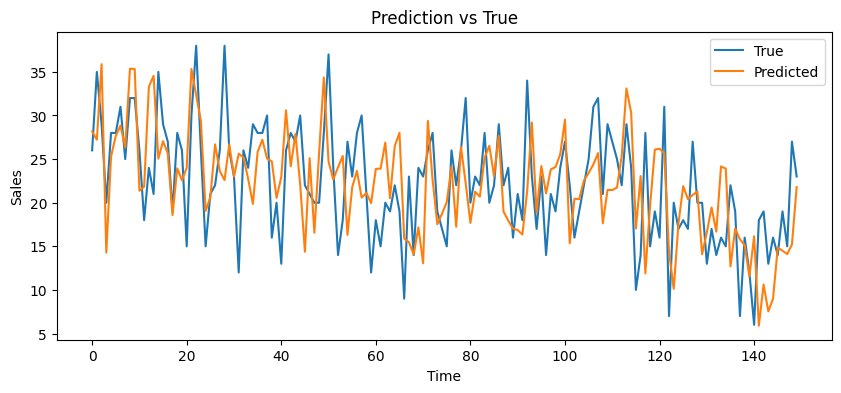

In [34]:
y_true = y_test
y_pred = pred_cnn

k = 150 if len(y_true) > 150 else len(y_true)

plt.figure(figsize=(10,4))
plt.plot(y_true[-k:], label="True")
plt.plot(y_pred[-k:], label="Predicted")
plt.title("Prediction vs True")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()